___

<center><h1>Big-Five Personality Test</h1></center>

___

<center><h2>Aprendizaje de Máquinas</h2></center>

___

<center>Mateo González <sup><strong><i>a</i></strong></sup></center>
<center>Alejandro Uribe <sup><strong><i>b</i></strong></sup></center>
<i><center><sup><strong>a</strong></sup>1037627601; <sup><strong>b</strong></sup>1037627601</center></i><br>
<center>June 2020</center>

___

In [1]:
# Common modules
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

# Data Preparation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, label_binarize, FunctionTransformer

# Modelling
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Testing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_confusion_matrix

# Introduction
The current project was developed following CRISP-DM workflow. *CRoss-Industry Standard Process for Data Mining* (CRISP-DM) is the most commonly used methodology for analytics, data mining and analytics projects which provides an overview of the life cycle of a data mining project. CRISP-DM is a robust industry standard process which guides the analyst through a set of phases which cover all possible data mining situations [1]. The Figure 1 shows the CRISP-DM Methodology.  
<img src="assets/CRISPDM.png" alt="CRISPDM" style="width: 500px;"/>
<center><i>Figure 1. CRISP-DM Methodology.<br>Source: [2].</i></center>

# Business Understanding
The first phase is the most important in the lifecycle of the project, the analysts can set expectations and success from the thorough understanding of the business requirements.
The problem at hand arises from the need to group the people according to their personality, thus simplifying the understanding of human mind. The “Big Five Personality Test” have widespread since its release in XX century due to its scalability and ease of distribution.
The optimal solution is a model able to classify the trait with max value of the test, given the answers of this one.

The Figure 2 shows the schedule followed by the team to carry out the project.

<img src="assets/ProjectSchedule.png" alt="ProjectSchedule" style="width: 950px;"/>
<center><i>Figure 2. Project Schedule.</i></center>

# Data Understanding
This phase involves collecting the data, describing its attributes and performing the data exploratory analysis. Firstly, the data can be found in open data sources, e.g., Kaggle [3] or can be purchased in third party companies.The data used to develop this project was provided by the instructors of the subject. 

## Data Load
This step includes 

In [2]:
answer_columns =    [f"EXT{i}" for i in range(1, 11)] + \
                    [f"EST{i}" for i in range(1, 11)] + \
                    [f"AGR{i}" for i in range(1, 11)] + \
                    [f"CSN{i}" for i in range(1, 11)] + \
                    [f"OPN{i}" for i in range(1, 11)]

time_columns =      [f"EXT{i}_E" for i in range(1, 11)] + \
                    [f"EST{i}_E" for i in range(1, 11)] + \
                    [f"AGR{i}_E" for i in range(1, 11)] + \
                    [f"CSN{i}_E" for i in range(1, 11)] + \
                    [f"OPN{i}_E" for i in range(1, 11)]

float32_columns = answer_columns + time_columns

float32_types = {k: 'float32' for k in float32_columns}
dtype = {**float32_types}

df = pd.read_csv('dataset/BigFivePersonalityTest-TrainSet.csv', parse_dates = ['dateload'], dtype = dtype)
df.rename(columns = {'Unnamed: 0' : 'id'}, inplace = True)

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 999

df.head()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err,target
0,441310,3.00,3.00,3.00,3.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,3.00,4.00,3.00,4.00,4.00,4.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,5.00,0.00,4.00,4.00,4.00,3.00,3.00,3.00,3.00,4.00,3.00,4.00,3.00,4.00,3.00,2.00,3.00,4.00,3.00,4.00,1.00,4.00,3.00,4.00,3.00,"6,462.00","2,273.00","1,625.00","4,960.00","6,040.00","3,983.00","3,608.00","3,376.00","3,216.00","4,544.00","2,913.00","13,480.00","3,008.00","3,496.00","4,640.00","2,274.00","2,080.00","2,535.00","2,545.00","1,719.00","5,432.00","4,696.00","2,319.00","1,944.00","5,008.00","2,698.00",0.00,"23,048.00","2,040.00","3,608.00","2,528.00","4,008.00","2,361.00","2,528.00","2,760.00","7,662.00","4,736.00","2,697.00","2,095.00","1,704.00","2,958.00","2,471.00","2,184.00","1,880.00","3,024.00","2,375.00","2,456.00","1,840.00","2,016.00","2,232.00",2017-06-25 19:21:21,"1,920.00","1,080.00",7.00,186.00,21,1,US,35.057,-79.0147,C
1,985842,3.00,4.00,4.00,3.00,2.00,3.00,5.00,2.00,4.00,4.00,3.00,4.00,4.00,1.00,2.00,2.00,4.00,4.00,4.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,4.00,5.00,3.00,3.00,3.00,2.00,2.00,4.00,3.00,3.00,3.00,2.00,4.00,1.00,5.00,1.00,4.00,1.00,5.00,4.00,4.00,5.00,"35,691.00","2,218.00","1,492.00","1,685.00","2,667.00","1,757.00","3,513.00",906.00,"1,211.00","2,013.00","1,401.00","2,884.00","1,100.00","1,276.00","1,416.00","5,026.00","1,142.00","1,518.00","1,761.00","2,382.00","1,426.00",995.00,"1,873.00","1,705.00","1,259.00","1,215.00","1,607.00","2,478.00","1,115.00","1,064.00","1,618.00","2,390.00","1,139.00","1,925.00","1,356.00","3,875.00","1,291.00","2,916.00","1,315.00","2,181.00","1,122.00",834.00,"2,201.00","10,365.00","1,283.00","1,490.00","2,185.00","1,318.00","1,227.00","1,247.00",2018-10-24 08:10:07,"1,366.00",768.00,15.00,133.00,7,14,SG,1.2931,103.8558,N
2,628988,3.00,3.00,2.00,3.00,2.00,3.00,1.00,2.00,2.00,5.00,2.00,4.00,2.00,1.00,4.00,3.00,2.00,3.00,4.00,4.00,3.00,4.00,1.00,2.00,4.00,4.00,2.00,2.00,4.00,3.00,2.00,2.00,2.00,4.00,1.00,4.00,4.00,4.00,0.00,2.00,2.00,2.00,5.00,1.00,3.00,2.00,3.00,3.00,4.00,4.00,"30,932.00","2,514.00","4,927.00","8,252.00","7,885.00","3,500.00","3,973.00","1,231.00","1,117.00","1,309.00",985.00,926.00,"1,133.00","5,290.00","33,489.00","3,101.00","2,600.00","12,058.00","6,068.00",684.00,"13,743.00","1,823.00","2,268.00","2,891.00","4,402.00","4,891.00","6,840.00","2,899.00","11,554.00","2,416.00","2,498.00","3,435.00","11,042.00","12,779.00","1,510.00","4,093.00","4,769.00","12,279.00",0.00,"9,355.00","4,027.00","4,616.00","1,974.00","2,000.00","3,203.00","4,126.00","2,514.00","4,169.00","1,800.00","5,787.00",2018-02-26 18:56:06,"1,680.00","1,050.00",3.00,286.00,16,11,HK,22.25,114.1667,N
3,704960,3.00,3.00,2.00,3.00,3.00,4.00,1.00,3.00,4.00,5.00,4.00,2.00,5.00,3.00,2.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,4.00,4.00,2.00,5.00,2.00,3.00,4.00,5.00,3.00,5.00,5.00,3.00,2.00,4.00,1.00,2.00,5.00,3.00,3.00,4.00,3.00,3.00,3.00,2.00,3.00,3.00,5.00,3.00,"8,624.00","2,872.00","5,600.00","3,152.00","5,775.00","1,753.00","4,208.00","5,648.00","7,136.00","1,704.00","2,361.00","7,576.00","2,360.00","5,584.00","3,328.00","2,728.00","2,567.00","2,880.00","1,120.00","4,376.00","3,113.00","1,681.00","2,400.00","3,415.00","3,921.00","3,120.00","4,672.00","4,344.00","4,064.00","3,457.00","3,071.00","2,920.00","2,792.00","1,9

## Data Description
Secondly, an initial analysis on the data will provided the very first insights about it such as its nature, volume, features and relationships. Finally, the Exploratory Data Analysis will be carried out 

### Volume of the data

In [3]:
print(f'The dataset has {df.shape[0]} records and {df.shape[1]} features.')

The dataset has 964573 records and 112 features.


### Metadata of the Dataset
- Data types
- Memory usage

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964573 entries, 0 to 964572
Columns: 112 entries, id to target
dtypes: datetime64[ns](1), float32(100), float64(4), int64(3), object(4)
memory usage: 456.3+ MB


### Features in the Dataset

In [5]:
df.columns.values

array(['id', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5',
       'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3',
       'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1',
       'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9',
       'CSN10', 'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7',
       'OPN8', 'OPN9', 'OPN10', 'EXT1_E', 'EXT2_E', 'EXT3_E', 'EXT4_E',
       'EXT5_E', 'EXT6_E', 'EXT7_E', 'EXT8_E', 'EXT9_E', 'EXT10_E',
       'EST1_E', 'EST2_E', 'EST3_E', 'EST4_E', 'EST5_E', 'EST6_E',
       'EST7_E', 'EST8_E', 'EST9_E', 'EST10_E', 'AGR1_E', 'AGR2_E',
       'AGR3_E', 'AGR4_E', 'AGR5_E', 'AGR6_E', 'AGR7_E', 'AGR8_E',
       'AGR9_E', 'AGR10_E', 'CSN1_E', 'CSN2_E', 'CSN3_E', 'CSN4_E',
       'CSN5_E', 'CSN6_E', 'CSN7_E', 'CSN8_E', 'CSN9_E', 'CSN10_E',
       'OPN1_E', 'OPN2_E', 'OPN3_E', 'OPN4_E', 'OPN5_E', 'OPN6_E',
       'OPN7_E', 'OPN8_E', 

Further information about the columns can be found in the table below.  

**Question Columns**  
Find below further information about the question columns  

|Feature| Question|
|:-:|:---|
|EXT1|I am the life of the party
|EXT2|I don't talk a lot
|EXT3|I feel comfortable around people
|EXT4|I keep in the background
|EXT5|I start conversations
|EXT6|I have little to say
|EXT7|I talk to a lot of different people at parties
|EXT8|I don't like to draw attention to myself
|EXT9|I don't mind being the center of attention
|EXT10|I am quiet around strangers
|EST1|I get stressed out easily
|EST2|I am relaxed most of the time
|EST3|I worry about things
|EST4|I seldom feel blue
|EST5|I am easily disturbed
|EST6|I get upset easily
|EST7|I change my mood a lot
|EST8|I have frequent mood swings
|EST9|I get irritated easily
|EST10|I often feel blue
|AGR1|I feel little concern for others
|AGR2|I am interested in people
|AGR3|I insult people
|AGR4|I sympathize with others' feelings
|AGR5|I am not interested in other people's problems
|AGR6|I have a soft heart
|AGR7|I am not really interested in others
|AGR8|I take time out for others
|AGR9|I feel others' emotions
|AGR10|I make people feel at ease
|CSN1|I am always prepared
|CSN2|I leave my belongings around
|CSN3|I pay attention to details
|CSN4|I make a mess of things
|CSN5|I get chores done right away
|CSN6|I often forget to put things back in their proper place
|CSN7|I like order
|CSN8|I shirk my duties
|CSN9|I follow a schedule
|CSN10|I am exacting in my work
|OPN1|I have a rich vocabulary
|OPN2|I have difficulty understanding abstract ideas
|OPN3|I have a vivid imagination
|OPN4|I am not interested in abstract ideas
|OPN5|I have excellent ideas
|OPN6|I do not have a good imagination
|OPN7|I am quick to understand things
|OPN8|I use difficult words
|OPN9|I spend time reflecting on things
|OPN10|I am full of ideas

<center><i>The scale was labeled 1=Disagree, 3=Neutral, 5=Agree</i></center>

The time spent on each question is also recorded in milliseconds These are the variables ending in **\_E**  

**Other Columns**  

|Feature|Description|
|:-:|:---|
|dateload|The timestamp when the survey was started
|screenw|The width the of user's screen in pixels
|screenh|The height of the user's screen in pixels
|introelapse|The time in seconds spent on the landing page
|testelapse|The time in seconds spent on the page with the survey questions
|endelapse|The time in seconds spent on the finalization page 
|IPC|The number of records from the user's IP address in the dataset
|country|The country*
|lat_appx_lots_of_err|Approximate latitude of user*
|long_appx_lots_of_err|Approximate longitude of user*
|target|The trait with max value of the test

<center><i>*Determined by technical information</i></center>

The data provider suggested to keep the values where `IPC = 1` because higher values correspond to either multiple submissions or tests in shared network.

In [6]:
def filter_IPC(df):
    return df[df['IPC']==1]

In [7]:
df = filter_IPC(df)

### Duplicated Values
Duplicated values will be deleted, keeping the first record.

In [8]:
def drop_dupl(df):
    df.drop_duplicates(keep = 'first', inplace = True)
    return df

In [9]:
df = drop_dupl(df)

### Missing Values
All answers labeled as zero will be considered as nulls, this records could be corrupted and will not add valuable information to model.

In [10]:
def missing_answers(df,answer_columns):
    df[answer_columns] = df[answer_columns].replace(to_replace = 0, value = np.nan)
    return df

In [11]:
df = missing_answers(df,answer_columns)
df.isnull().sum()[df.isnull().sum()>0].to_frame('Nulls %').sort_values(by = 'Nulls %')/len(df)*100

,Nulls %
country,0.01
AGR5_E,0.17
AGR4_E,0.17
AGR3_E,0.17
AGR2_E,0.17
...,...
EST2,1.07
AGR6,1.14
EST4,1.17
EST6,1.20


The NaN values represent the 1.3% of the dataset in the worst case, then this values will be dropped.

In [12]:
def drop_missing(df):
    df.dropna(axis = 0, inplace = True)
    return df

In [13]:
df = drop_missing(df)

### Descriptive Analysis

In [14]:
df.describe()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00","572,511.00"
mean,"505,444.07",2.58,2.85,3.23,3.22,3.25,2.42,2.71,3.47,2.95,3.62,3.31,3.17,3.88,2.66,2.86,2.87,3.07,2.70,3.10,2.86,2.24,3.85,2.27,3.95,2.30,3.76,2.24,3.68,3.79,3.60,3.32,3.00,4.01,2.65,2.58,2.86,3.73,2.49,3.16,3.63,3.78,2.02,4.07,1.95,3.83,1.88,4.06,3.28,4.22,4.00,"100,871.66","7,677.19","9,275.62","7,361.36","7,909.66","5,896.34","7,745.27","6,988.27","5,683.44","5,271.37","8,503.14","8,302.53","6,599.40","10,855.17","6,859.52","8,476.85","6,214.01","5,273.17","5,029.04","4,594.47","17,756.53","8,937.98","6,627.69","8,241.99","8,011.33","5,436.05","7,719.26","9,911.55","5,080.96","5,698.43","12,924.37","9,897.33","8,637.91","7,681.20","9,817.24","9,800.40","5,162.87","10,450.31","5,155.19","9,053.48","9,110.55","13,151.10","6,454.26","8,333.57","6,048.42","7,224.37","7,643.57","4,864.72","5,665.60","4,293.36","1,116.30",822.17,"1,029.65",636.99,"3,798.72",1.00
std,"296,401.19",1.24,1.31,1.19,1.21,1.25,1.21,1.37,1.24,1.32,1.26,1.31,1.19,1.12,1.23,1.25,1.29,1.27,1.32,1.27,1.31,1.31,1.09,1.26,1.08,1.16,1.17,1.11,1.05,1.14,1.04,1.12,1.37,1.00,1.24,1.24,1.40,1.07,1.13,1.25,1.00,1.08,1.08,1.03,1.06,0.93,1.07,0.92,1.21,0.94,0.98,"5,862,489.50","467,949.97","1,038,618.00","304,415.53","769,300.50","291,479.22","245,300.28","392,072.41","136,834.17","251,641.67","549,775.44","405,470.81","382,706.66","1,402,635.25","239,782.67","788,556.06","283,376.66","102,445.30","315,105.00","161,543.89","1,975,738.38","859,726.56","288,759.16","616,281.56","349,840.97","207,462.12","524,470.88","1,830,228.38","124,906.59","191,978.16","1,546,176.25","506,103.97","1,494,663.00","381,828.03","1,318,363.62","848,351.88","199,179.38","501,934.72","228,730.89","663,807.44","1,187,057.25","1,507,845.38","307,454.19","432,861.56","356,243.28","432,880.91","672,039.12","114,339.72","208,788.97","188,218.77",582.09,185.65,"60,302.79","15,485.95","1,975,323.20",0.00
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,

Target variable `target` will be analyzed in **Exploratory Data Analysis** section.  

Negative Values and Outliers can be found in time columns, this values will be transformed in **Data Transformation** section.  

In addition, the scale of these records will be narrowed from miliseconds to minutes, as follows:

In [15]:
def narrow_time_cols(df):
    for col in time_columns:
        df[col] = df[col].apply(lambda x: x/1000/60)
    return df

In [16]:
df = narrow_time_cols(df)

Check the distribution of the variable in order to have an insight of its outliers.

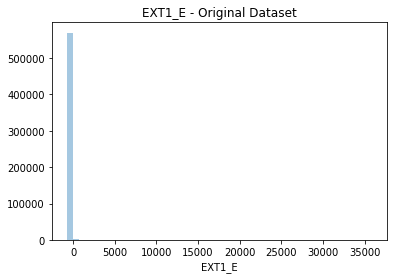

In [17]:
sns.distplot(df['EXT1_E'],kde=False)
plt.title('EXT1_E - Original Dataset')
plt.show()

Following the example above, there is a tail on the right probably due to errors in the calcaulation of the timeframe.

## Exploratory Data Analysis


### Target Variable
This variable corresponds to the trait with max value of the test. Further information about the traits can be found below.  

|Trait|Class|Description|
|:--:|:--:|:---|
|Extroversion|E|**High scores:** People who tend to be social<br>**Low scores:** People who prefer to work alone in projects|
|Agreeableness|A|**High scores:** Politically correct people<br>**Low Scores:** Direct people|
|Conscientiousness|C|**High Scores:** People who tend to follow the rules and prefer order<br>**Low Scores:** People who tend to be disorganized|
|Neuroticism|N|How emotional the person can be|
Openness to Experience|O|**High Scores:** People who tend to “dream with their eyes open”<br>**Low Scores:** People who tend to “have their feet on the ground”|

In [18]:
target_classes = list(df['target'].unique())
print(f'Unique classes in target variable: {target_classes}')

Unique classes in target variable: ['C', 'N', 'O', 'E', 'A']


#### Distribution
Plese find below an distribution analysis of the target variable.

##### Balance of Classes

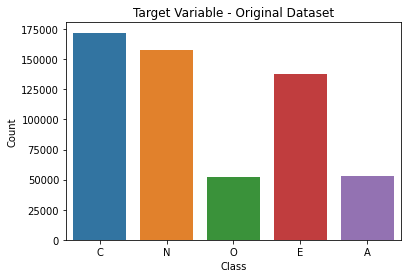

In [19]:
sns.countplot(df['target'],order = target_classes)
plt.title('Target Variable - Original Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

##### Distribution in Test Answers

###### Globally

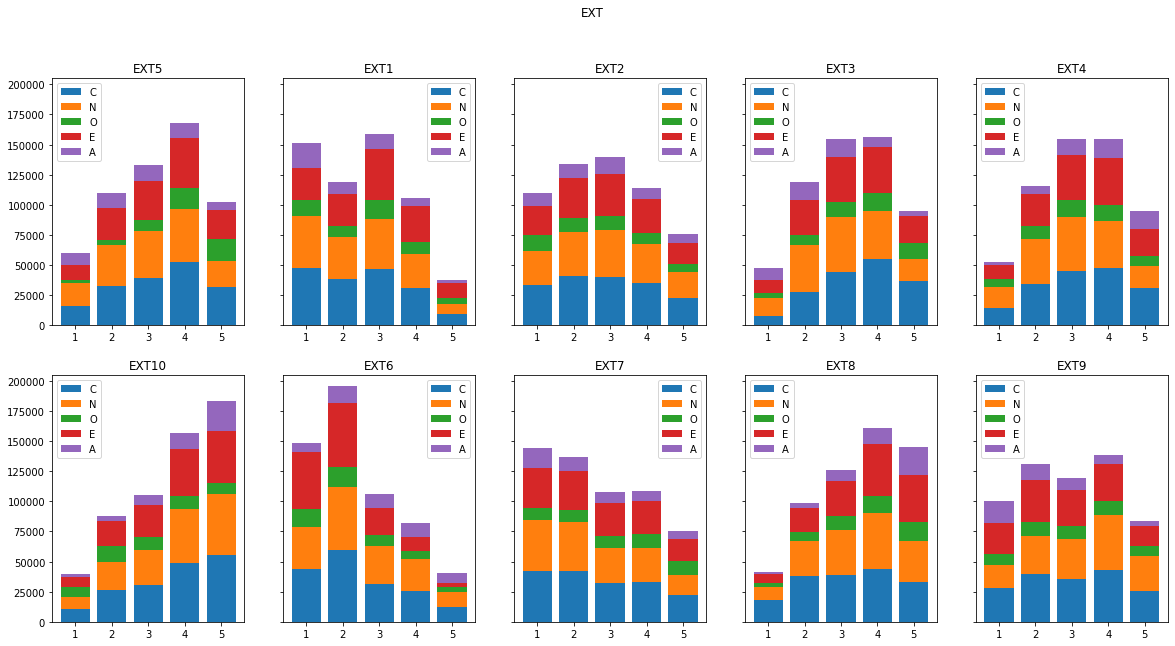

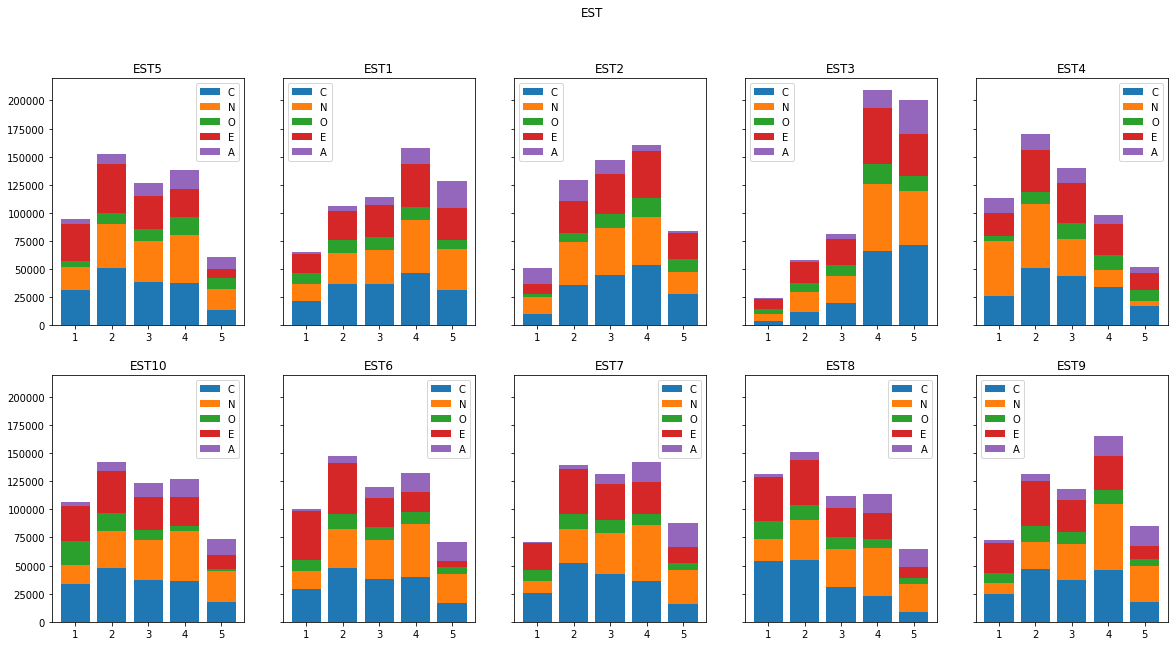

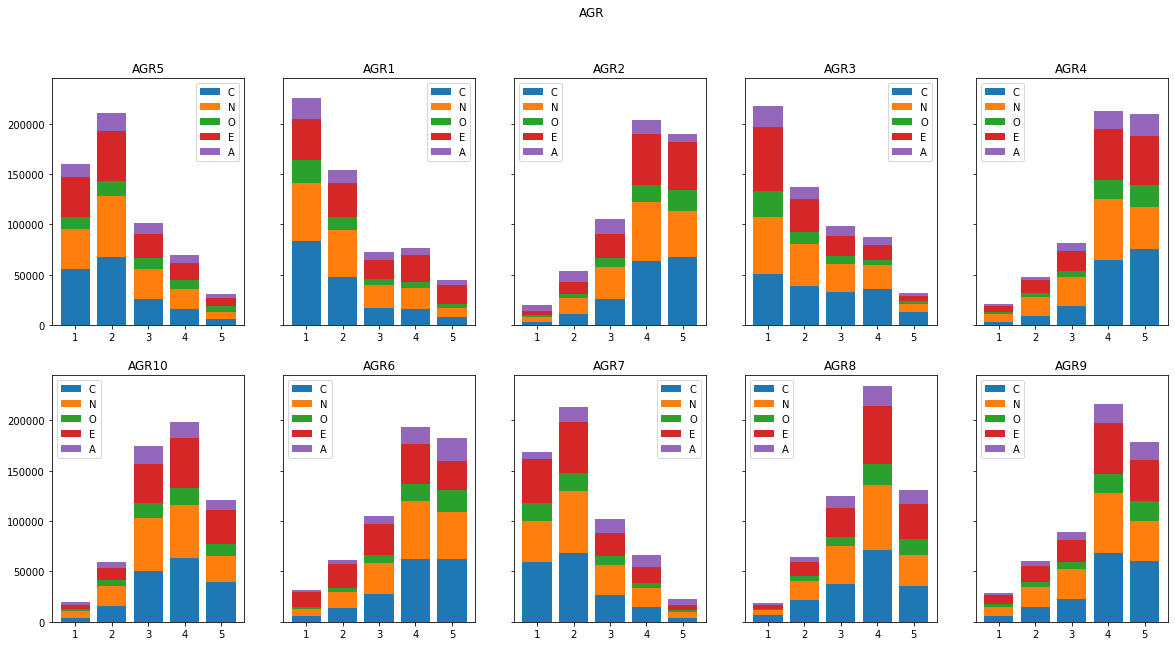

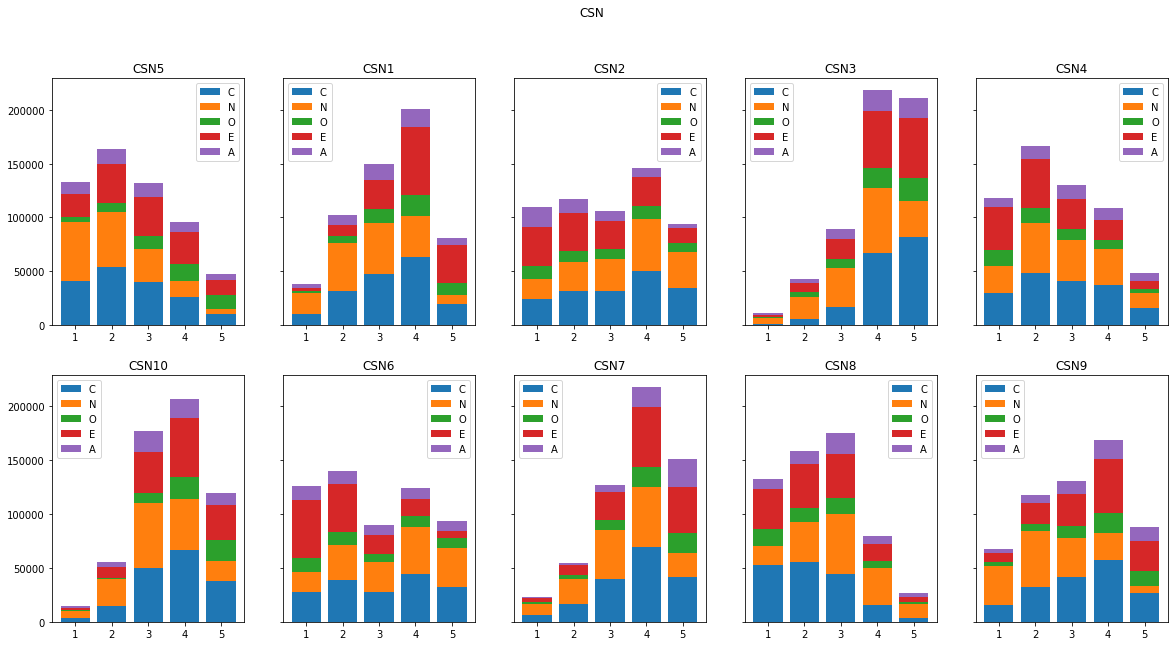

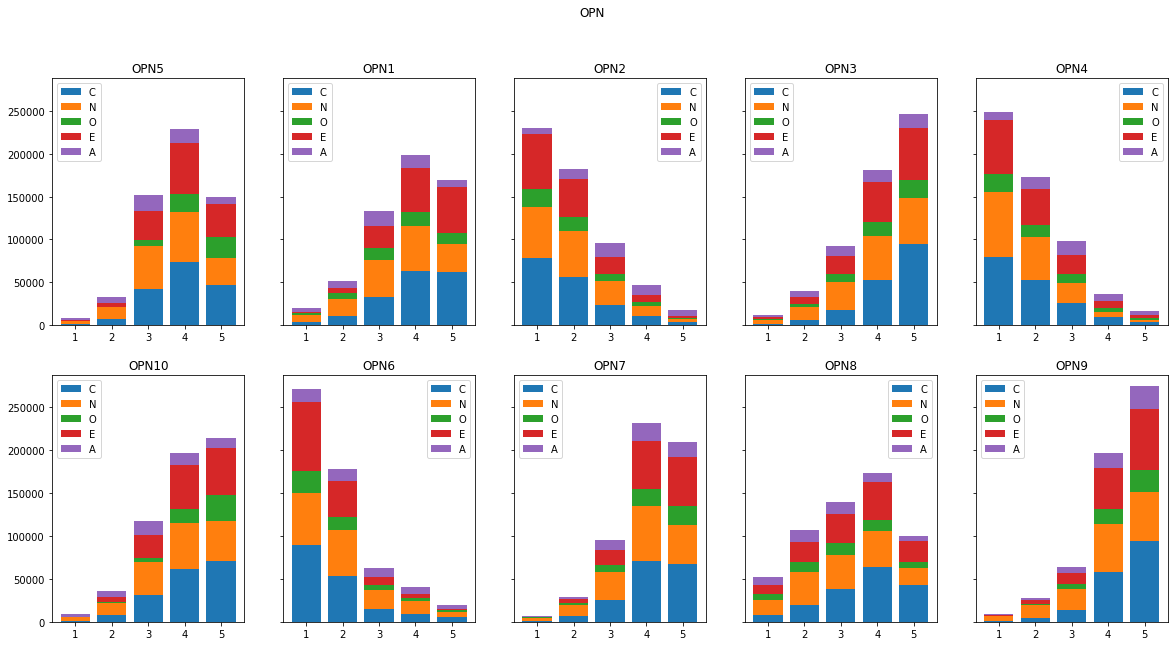

In [20]:
q_types = ['EXT', 'EST', 'AGR', 'CSN', 'OPN']
targets = df['target'].unique()

for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for i, question in enumerate(questions):
        ax = axis[round((i+1)/10), (i + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        cumsum = np.cumsum(targets_data, axis=0)
        for i in range(len(targets_data)):
            if i == 0:
                ax.bar(targets_data[i].index, targets_data[i], label=targets[i])
            else:
                ax.bar(targets_data[i].index, targets_data[i], bottom=cumsum[i - 1], label=targets[i])

            ax.legend()

###### Per target

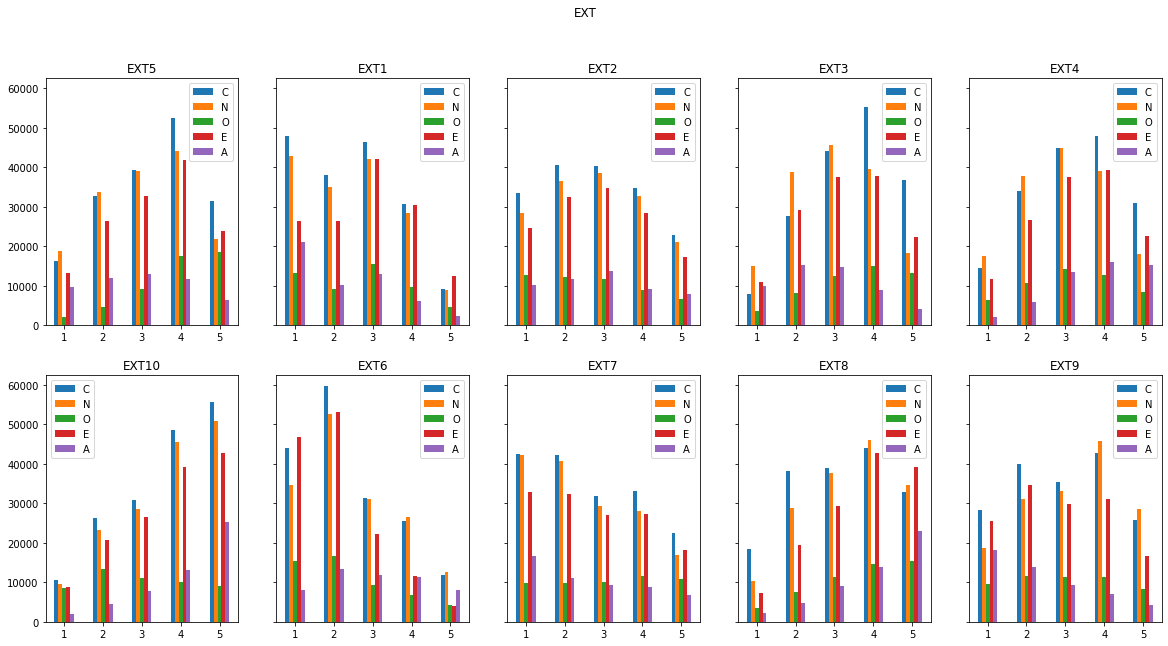

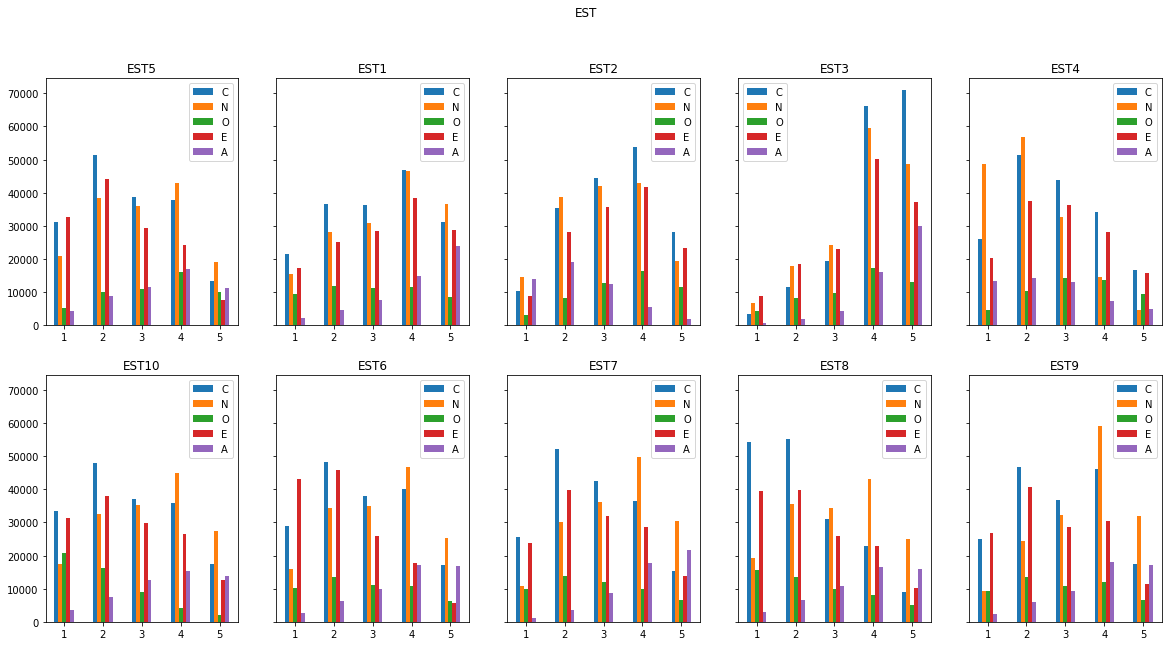

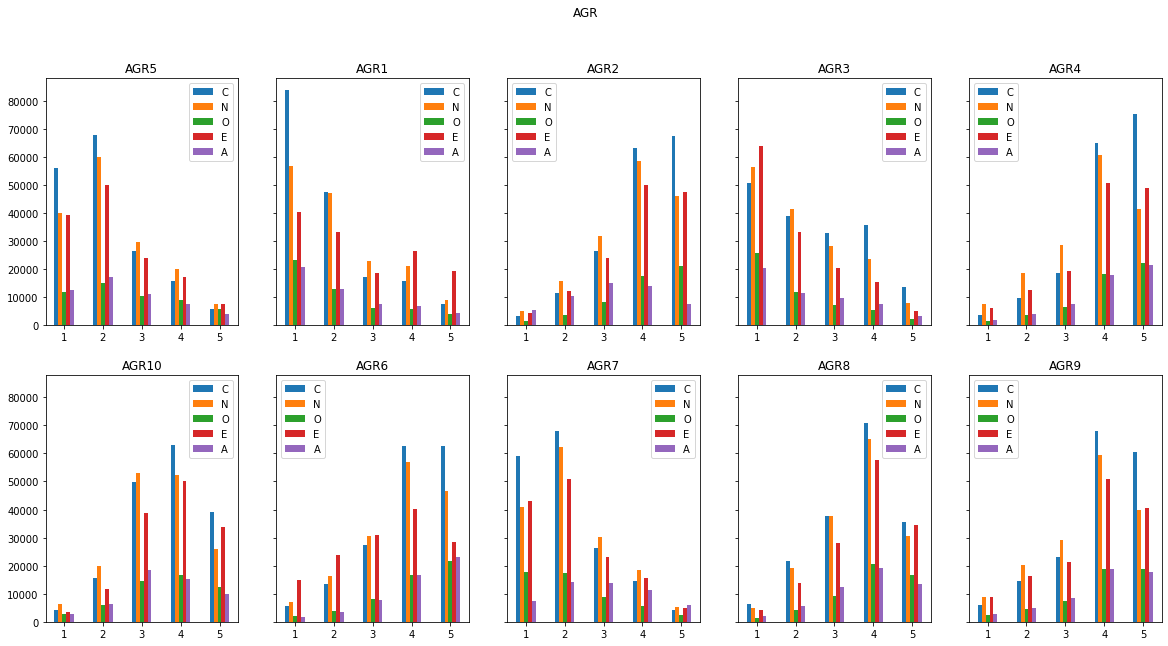

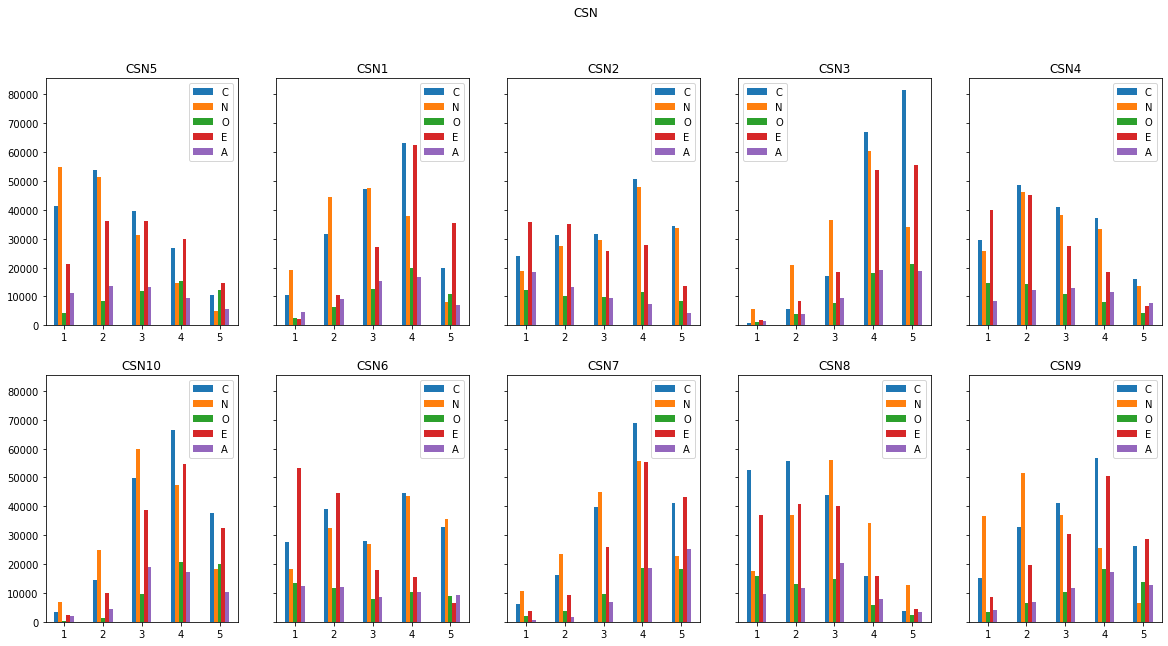

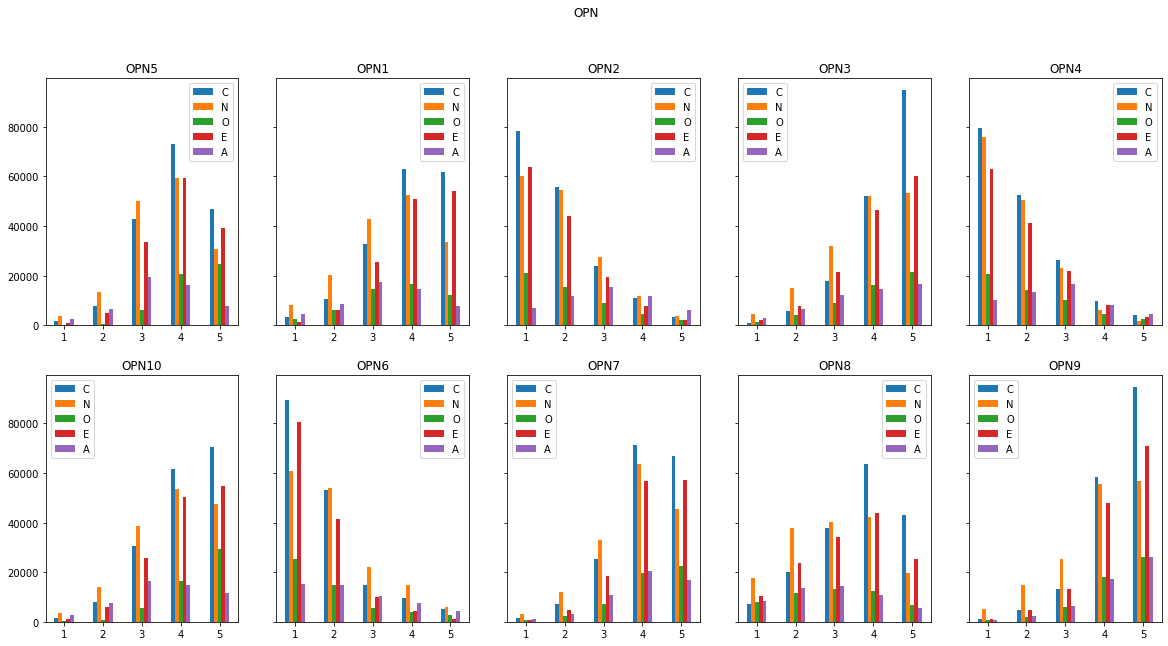

In [21]:
width = 0.1
for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for j, question in enumerate(questions):
        ax = axis[round((j+1)/10), (j + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        for i in range(len(targets_data)):
            ax.bar(targets_data[i].index + (i - 2) * width, targets_data[i], width, label=targets[i])
            ax.set_xticks(targets_data[i].index)
            ax.legend()

## Data Preparation

Columns containing IDs, dates, computer specifications and geographic information do not add valuable information to solve the problem at hand. These will be deleted from the dataset.

In [22]:
def drop_other_cols(df):
    labels = ['id','dateload','screenw','screenh','IPC','testelapse','endelapse',
              'introelapse','country','lat_appx_lots_of_err','long_appx_lots_of_err']
    df.drop(labels = labels, inplace = True, axis = 1)
    return df

In [23]:
df = drop_other_cols(df)

According to the descriptive analysis of the dataset the columns referencing the time spent answering questions contain incoherent information (negative values) and a significant presence of outliers.  

- Conversion of the record from milliseconds to minutes
- Trim of inconsistent data

The time values higher than 2 minutes will not be taken into account.

In [24]:
def trim_time_cols(df):
    for col in time_columns:
        df = df[(df[col]>0) & (df[col]<=2)]
    return df

In [25]:
df = trim_time_cols(df)

Check the change on the distribution of the feature.

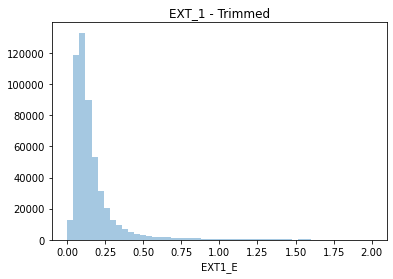

In [26]:
sns.distplot(df['EXT1_E'],kde=False)
plt.title('EXT_1 - Trimmed')
plt.show()

A change on its distibution was noticed.

In [27]:
print(f'The filtered dataset has {df.shape[0]} records and {df.shape[1]} features.')

The filtered dataset has 525139 records and 101 features.


### Categorical Values
The distinct classes in the target variable had been encoded from character to integer numbers.

## Feature Selection

### Chi-Squared
Selecting the Best k Features

In [28]:
bestfeatures = SelectKBest(score_func=chi2, k=52)
fit = bestfeatures.fit(df.drop('target',axis=1),df['target'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop('target',axis=1).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
featureScores.sort_values(by='Score',ascending=False).head(52)

,Feature,Score
17,EST8,"40,541.23"
35,CSN6,"37,417.06"
15,EST6,"35,653.24"
38,CSN9,"34,103.65"
34,CSN5,"29,502.59"
16,EST7,"28,416.33"
19,EST10,"27,715.17"
41,OPN2,"25,621.23"
18,EST9,"24,241.63"
30,CSN1,"23,235.48"


The time columns will be dropped, as well as, the last two columns which lowest score following Chi-Squared results. Keeping 50 features in total.

In [29]:
def select_features(df,time_columns):
    df.drop(labels = time_columns, axis=1,inplace = True)
    return df

In [30]:
df = select_features(df,time_columns)
col = df.drop('target',axis=1).columns.values
print(f'Models will be trained with the following features\n{col}')

Models will be trained with the following features
['EXT1' 'EXT2' 'EXT3' 'EXT4' 'EXT5' 'EXT6' 'EXT7' 'EXT8' 'EXT9' 'EXT10'
 'EST1' 'EST2' 'EST3' 'EST4' 'EST5' 'EST6' 'EST7' 'EST8' 'EST9' 'EST10'
 'AGR1' 'AGR2' 'AGR3' 'AGR4' 'AGR5' 'AGR6' 'AGR7' 'AGR8' 'AGR9' 'AGR10'
 'CSN1' 'CSN2' 'CSN3' 'CSN4' 'CSN5' 'CSN6' 'CSN7' 'CSN8' 'CSN9' 'CSN10'
 'OPN1' 'OPN2' 'OPN3' 'OPN4' 'OPN5' 'OPN6' 'OPN7' 'OPN8' 'OPN9' 'OPN10']


### Correlation Matrix
The following matrix gives an insight of the strengt of linear association between independent variables.

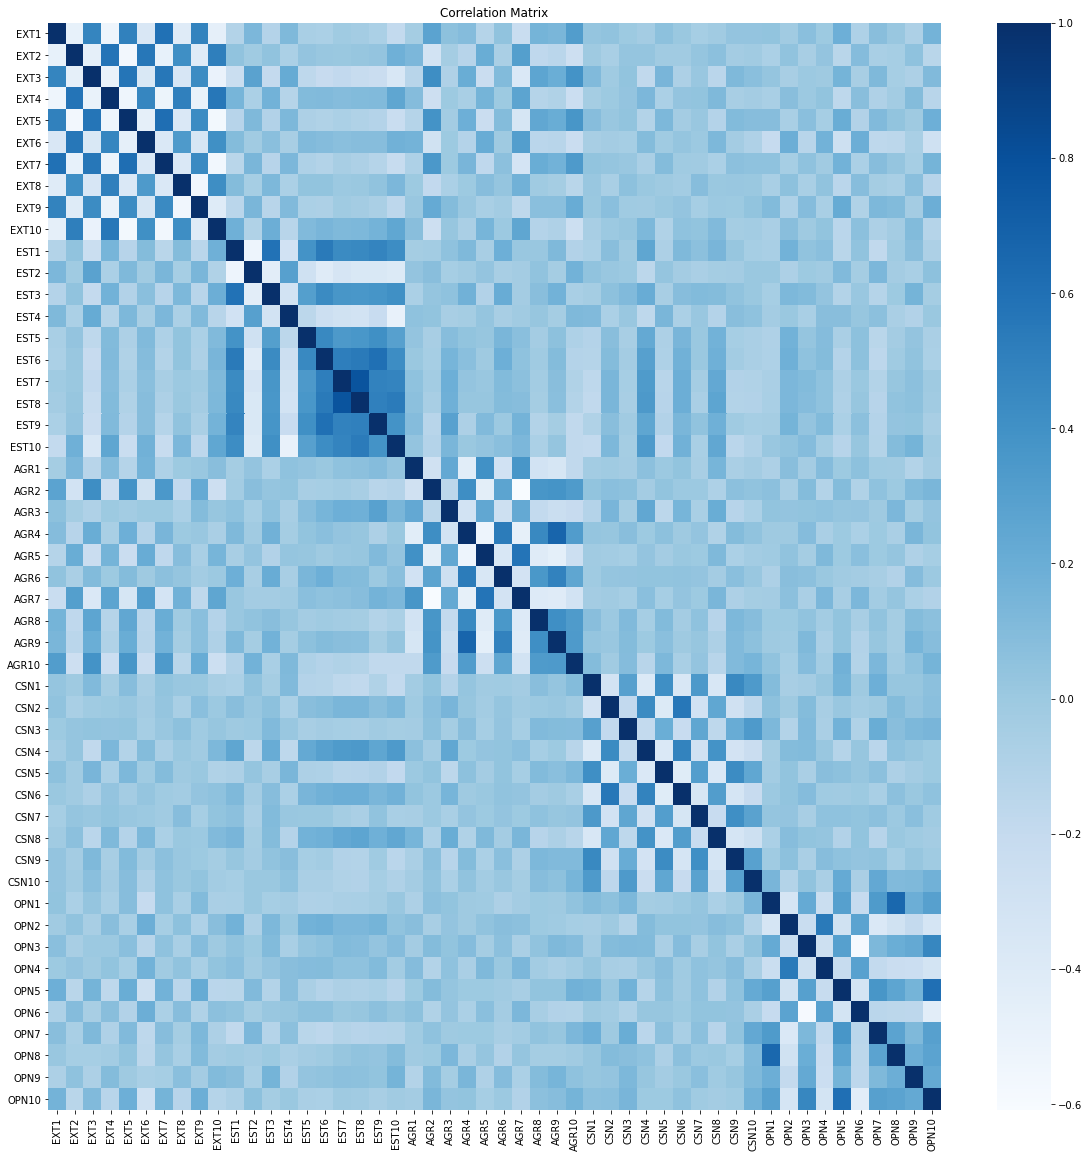

In [31]:
corr = df.drop('target',axis=1).corr(method='pearson')
fig,ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(corr,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

Some clusters along common topic of anwers can be found in the correlation matrix, but there is no significant correlation between variables which can lead to an issue of multicolinearity.

# Modelling
The problem at hand requires an algorithm that maps the input data to the specific category, as well as, it will predict the class for the new data. Different classifiers can be found, 

- **Binary Classification:** Classification task with two possible outcomes, e.g., Gender classification (Male/Female)
- **Multi-class classification:** Classification with more than two classes. In multi-class classification, each sample is assigned to one and only one target label, e.g., an animal can be a cat or dog but not both at the same time.
- **Multi-label classification:** Classification task where each sample is mapped to a set of target labels (more than one class), e.g., a news article can be about sports, a person, and location at the same time.

The problem at hand might be tackled with a Multi-Class Classifier.

Due to the fact that the distinct classes in target variable are imbalanced, two approaches to solve this problem will be followed:
- Undersampling the data
- Oversampling the data

## Undersampled Dataset
Start by randomly dropping records in the dataset in order to balance the proportion if distinct classes in target variable. Then the undersampled dataset will be split into training and testing set.

In [32]:
sm = RandomUnderSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, 
                                                    random_state=0, shuffle=True, stratify = y_res)

The balance of the distinct classes in the target variable will be checked as follows.

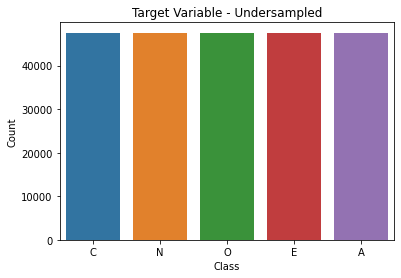

In [33]:
sns.countplot(y_res,order = target_classes)
plt.title('Target Variable - Undersampled')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Create a dictionary to store the trained models.

In [34]:
models_us = {}

### Logistic Regression

In [35]:
%%time
logistic = LogisticRegression(solver = 'lbfgs', n_jobs=-1, max_iter=350, random_state=0)
logistic.fit(X_train, y_train)
models_us[str(type(logistic).__name__)] = logistic

CPU times: user 549 ms, sys: 160 ms, total: 710 ms
Wall time: 55.1 s


### Decision Tree Classifier

In [36]:
%%time
tree = DecisionTreeClassifier(random_state = 0, max_depth = 30, criterion = "gini", max_features = 50,
                              min_samples_leaf = 45, min_samples_split = 45, ccp_alpha = 0.000001)
tree.fit(X_train,y_train)
models_us[str(type(tree).__name__)] = tree

CPU times: user 3.72 s, sys: 8.03 ms, total: 3.73 s
Wall time: 3.73 s


### Random Forest

In [37]:
%%time
randomf = RandomForestClassifier(random_state = 0, bootstrap = True,   criterion = "gini", min_samples_leaf = 45, 
                                 max_features = 50, max_depth = 30,min_samples_split = 45, n_estimators = 40,
                                 n_jobs = -1)
randomf.fit(X_train,y_train)
models_us[str(type(randomf).__name__)] = randomf

CPU times: user 3min 14s, sys: 322 ms, total: 3min 14s
Wall time: 55.4 s


### Bayes Classifier

In [38]:
%%time
bayes = CategoricalNB()
bayes.fit(X_train, y_train)
models_us[str(type(bayes).__name__)] = bayes

CPU times: user 1.27 s, sys: 16.2 ms, total: 1.29 s
Wall time: 1.29 s


## Error Analysis

Function which plots the confusion matrix for multiple models.

In [39]:
def plot_conf_mat(models,X,y,label):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.suptitle(f'Confusion Matrix - {label}',fontsize=16)

    for model, ax in zip(models, axes.flatten()):
        estimator = models[str(model)]

        plot_confusion_matrix(estimator, 
                              X, 
                              y, 
                              ax=ax, 
                              cmap='Blues',
                              normalize= 'all',
                              values_format = '.2f',
                              display_labels=list(estimator.classes_))
        ax.title.set_text(type(estimator).__name__)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
    plt.show()

Function which prints the classification report for each model.

In [40]:
def classif_report(models,X_test,y_test):
    for model in models:

        estimator = models[str(model)]
        y_pred = models[str(model)].predict(X_test)
        report = classification_report(y_test,y_pred,
                                       output_dict=True,
                                       target_names=list(estimator.classes_))
        clsf_report = pd.DataFrame(report).transpose()
        print(model+ '\n' + str(clsf_report) + '\n')

Function which print the accuracy of the models.

In [41]:
def accuracy_score_models(models,X_test):
    for model in models:
        estimator = models[str(model)]
        y_pred = estimator.predict(X_test)
        print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),3))

Function which plots ROC Curve for the multiclass case.

In [42]:
def pr_roc_curves_multiclass(estimator,X,y,label = None):
    # Binarize the output
    y = label_binarize(y, classes=list(estimator.classes_))
    n_classes = y.shape[1]

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0,shuffle=True,stratify = y)

    # Learn to predict each class against the other
    y_score = estimator.decision_function(X_test)
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    #Compute Precision-Recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    
    # Compute micro-average ROC curve and ROC area and aggregate all false positive rates
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,average="micro")


    
    # Setup plot details
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkviolet','gold','blue'])
    lw = 2

    # Plot Precision - Recall curves
    # Plot iso-F1 curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = ax[0].plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = ax[0].plot(recall["micro"], precision["micro"], linestyle=':', color='deeppink', lw=4)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'''.format(average_precision["micro"]))
    
    # Plot ROC Curves
    ax[1].plot(fpr["micro"], tpr["micro"],
             color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]))

    ax[1].plot(fpr["macro"], tpr["macro"],
             color='navy', linestyle=':', linewidth=4,
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]))

    
    for i, color in zip(range(n_classes), colors):
        class_ref = list(estimator.classes_)[i]
        # Plot Precision - Recall curves for each class
        l, = ax[0].plot(recall[i], precision[i], color=color, lw=lw)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'''.format(class_ref, average_precision[i]))
        
        # Same for ROC curves
        ax[1].plot(fpr[i], tpr[i], color=color, lw=lw,
                   label='ROC curve of class {0} (area = {1:0.2f})'''.format(class_ref,roc_auc[i]))

    
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.01])
    ax[0].set_xlabel('Recall',fontsize=12)
    ax[0].set_ylabel('Precision',fontsize=12)
    ax[0].set_title(f'Precision-Recall Curve - {type(estimator).__name__} {label}',fontsize=12)
    ax[0].legend(lines, labels, loc=(0, -.45), prop=dict(size=12),frameon = False,fontsize=12)
    
    ax[1].plot([0, 1], [0, 1], 'k--', lw=lw)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.01])
    ax[1].set_xlabel('False Positive Rate',fontsize=12)
    ax[1].set_ylabel('True Positive Rate',fontsize=12)
    ax[1].set_title(f'ROC Curve - {type(estimator).__name__} {label}',fontsize=12)
    ax[1].legend(loc=(0, -.45), prop=dict(size=12),frameon=False,fontsize=12)

    plt.show()

### Confusion Matrix

#### Training Data

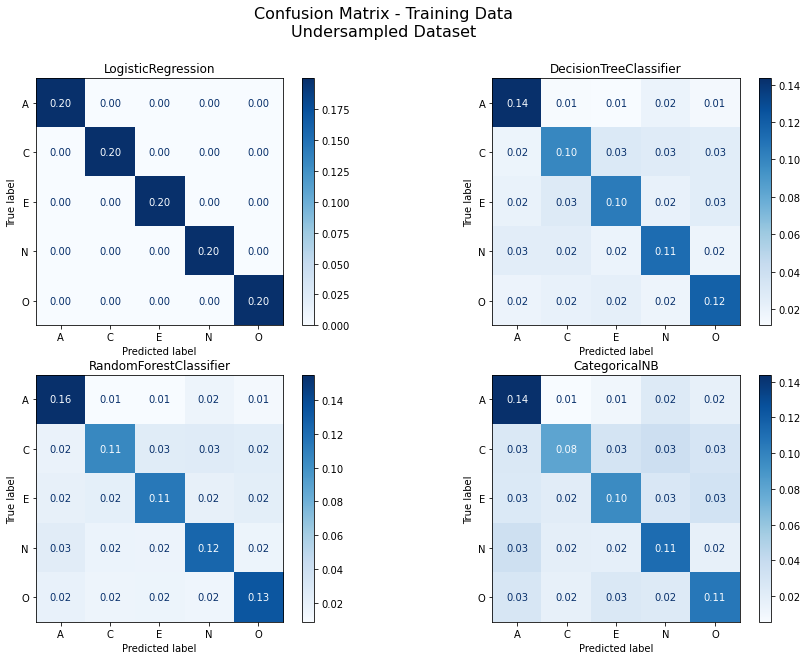

In [43]:
plot_conf_mat(models_us,X_train,y_train,label='Training Data\nUndersampled Dataset')

#### Validation Data

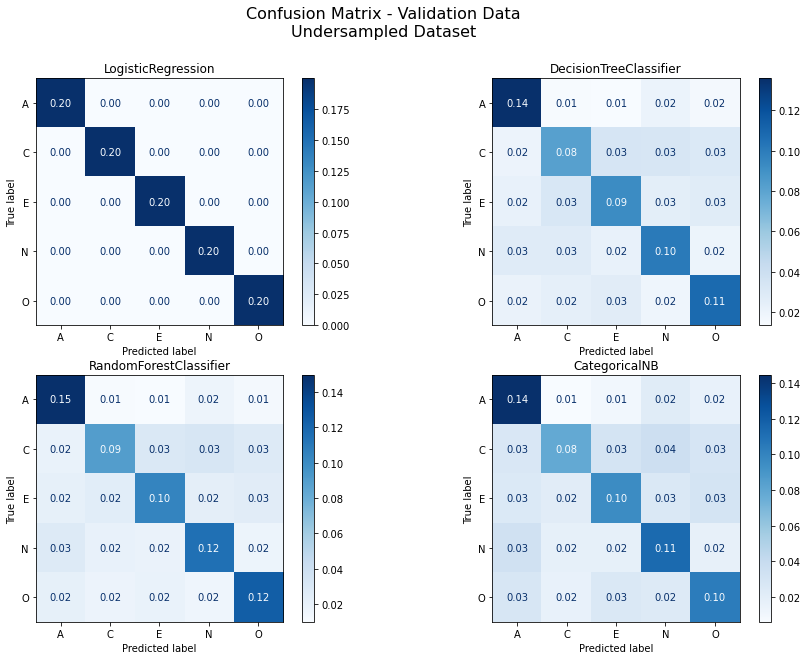

In [44]:
plot_conf_mat(models_us,X_test,y_test,label='Validation Data\nUndersampled Dataset')

### Classification Report

In [45]:
classif_report(models_us,X_test,y_test)

LogisticRegression
              precision  recall  f1-score   support
A                  1.00    1.00      1.00  9,511.00
C                  1.00    1.00      1.00  9,511.00
E                  1.00    1.00      1.00  9,511.00
N                  1.00    1.00      1.00  9,512.00
O                  1.00    1.00      1.00  9,512.00
accuracy           1.00    1.00      1.00      1.00
macro avg          1.00    1.00      1.00 47,557.00
weighted avg       1.00    1.00      1.00 47,557.00

DecisionTreeClassifier
              precision  recall  f1-score   support
A                  0.60    0.68      0.64  9,511.00
C                  0.45    0.41      0.43  9,511.00
E                  0.49    0.46      0.48  9,511.00
N                  0.51    0.50      0.51  9,512.00
O                  0.54    0.54      0.54  9,512.00
accuracy           0.52    0.52      0.52      0.52
macro avg          0.52    0.52      0.52 47,557.00
weighted avg       0.52    0.52      0.52 47,557.00

RandomForestClassifi

### Accuracy Score

In [46]:
accuracy_score_models(models_us,X_test)

LogisticRegression 0.998
DecisionTreeClassifier 0.52
RandomForestClassifier 0.584
CategoricalNB 0.536


### Precision-Recall & ROC Curve - Best Model

<ipython-input-42-d328a86e9fcb>:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


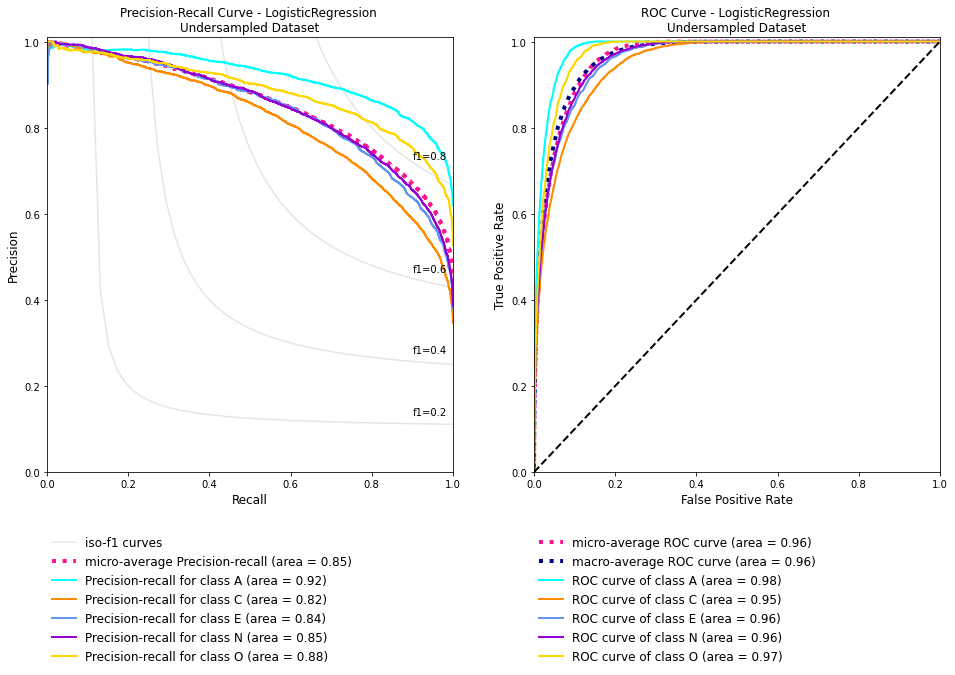

In [47]:
pr_roc_curves_multiclass(models_us['LogisticRegression'], X_res, y_res, label = '\nUndersampled Dataset')

The Precision-Recall curve shows that the classifer has a room of improvement related to C,E,N classes mainly. In contrast ROC Curve and AUC shows that the model is good predicting the classes

## Oversampled Dataset
Start by randomly Copying records in the dataset in order to balance the proportion if distinct classes in target variable. Then the undersampled dataset will be split into training and testing set.

In [48]:
sm = RandomOverSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, 
                                                    random_state=0,shuffle=True, stratify = y_res)

The balance of the distinct classes in the target variable will be checked as follows.

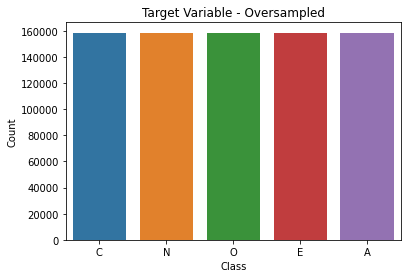

In [49]:
sns.countplot(y_res,order=target_classes)
plt.title('Target Variable - Oversampled')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Create a dictionary to store the trained models.

In [50]:
models_os = {}

### Logistic Regression

In [51]:
%%time
logistic.fit(X_train, y_train)
models_os[str(type(logistic).__name__)] = logistic

CPU times: user 997 ms, sys: 88 ms, total: 1.09 s
Wall time: 3min 21s


### Decision Tree Classifier

In [52]:
%%time
tree.fit(X_train,y_train)
models_os[str(type(tree).__name__)] = tree

CPU times: user 16.7 s, sys: 8.27 ms, total: 16.7 s
Wall time: 16.7 s


### Random Forest

In [53]:
%%time
randomf.fit(X_train,y_train)
models_os[str(type(randomf).__name__)] = randomf

CPU times: user 15min 17s, sys: 3.63 s, total: 15min 20s
Wall time: 4min 45s


### Bayes Classifier

In [54]:
%%time
bayes.fit(X_train, y_train)
models_os[str(type(bayes).__name__)] = bayes

CPU times: user 7.01 s, sys: 67.9 ms, total: 7.07 s
Wall time: 7.12 s


## Error Analysis

### Confusion Matrix

#### Training Data

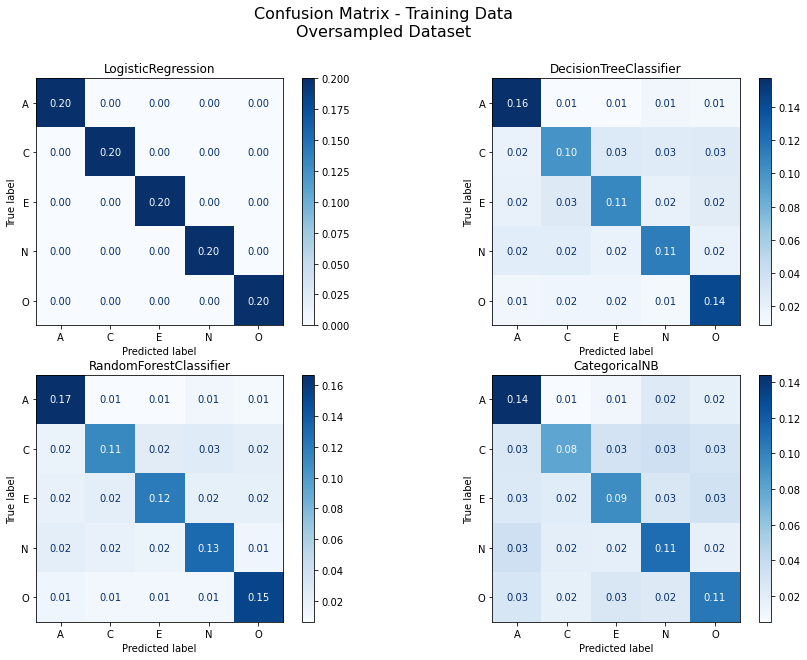

In [55]:
plot_conf_mat(models_os,X_train,y_train,label='Training Data\nOversampled Dataset')

#### Validation Data

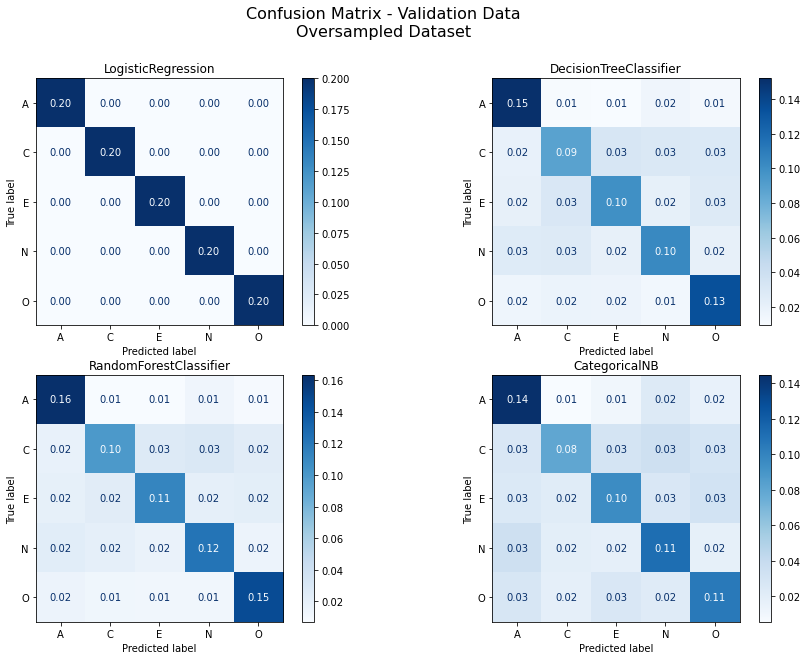

In [56]:
plot_conf_mat(models_os,X_test,y_test,label='Validation Data\nOversampled Dataset')

### Classification Report

In [57]:
classif_report(models_os,X_test,y_test)

LogisticRegression
              precision  recall  f1-score    support
A                  1.00    1.00      1.00  31,702.00
C                  1.00    1.00      1.00  31,702.00
E                  1.00    1.00      1.00  31,702.00
N                  1.00    1.00      1.00  31,702.00
O                  1.00    1.00      1.00  31,702.00
accuracy           1.00    1.00      1.00       1.00
macro avg          1.00    1.00      1.00 158,510.00
weighted avg       1.00    1.00      1.00 158,510.00

DecisionTreeClassifier
              precision  recall  f1-score    support
A                  0.64    0.76      0.70  31,702.00
C                  0.50    0.44      0.47  31,702.00
E                  0.55    0.50      0.52  31,702.00
N                  0.56    0.52      0.54  31,702.00
O                  0.60    0.67      0.63  31,702.00
accuracy           0.58    0.58      0.58       0.58
macro avg          0.57    0.58      0.57 158,510.00
weighted avg       0.57    0.58      0.57 158,510.00

Ra

### Accuracy Score

In [58]:
accuracy_score_models(models_os,X_test)

LogisticRegression 1.0
DecisionTreeClassifier 0.577
RandomForestClassifier 0.644
CategoricalNB 0.537


### Precision-Recall & ROC Curve  - Best Model

<ipython-input-42-d328a86e9fcb>:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


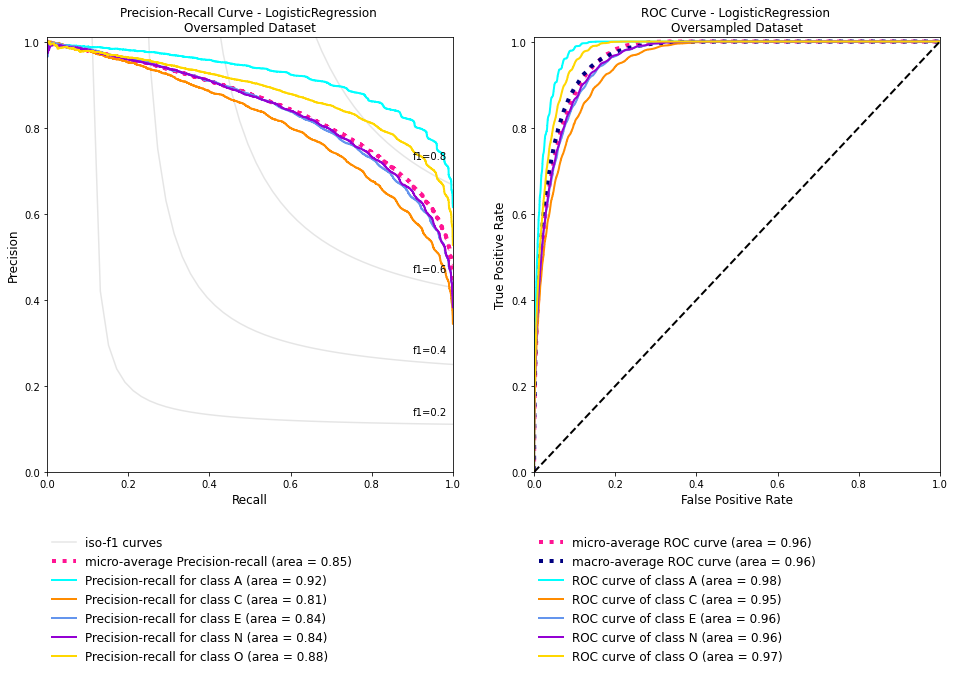

In [59]:
pr_roc_curves_multiclass(models_os['LogisticRegression'],X_res,y_res, label = '\nOversampled Dataset')

# Model Selection

In [60]:
model = models_us['LogisticRegression']

# Deployment

In [61]:
joblib.dump(model, 'big_five.pkl')

['big_five.pkl']

# Test Set

In [62]:
df_test = pd.read_csv('test_set/BigFivePersonalityTest-TrainSetWithoutTarget.csv',index_col = 0)
df_test.rename(columns = {'ID':'id'},inplace = True)
df_test.shape

(50768, 111)

In [63]:
df_test = filter_IPC(df_test)
df_test = drop_dupl(df_test)
df_test = missing_answers(df_test,answer_columns)
df_test = drop_missing(df_test)
df_test = narrow_time_cols(df_test)

ids = df_test['id'].reset_index(drop=True)
df_test = drop_other_cols(df_test)
df_test = select_features(df_test,time_columns)
df_test.shape

(30131, 50)

In [64]:
results = pd.DataFrame(model.predict(df_test),columns={'Class'})

In [65]:
pd.concat([ids,results],axis=1)

,id,Class
0,4,C
1,6,C
2,9,E
3,10,C
4,12,A
...,...,...
30126,50755,C
30127,50760,E
30128,50761,C
30129,50762,N


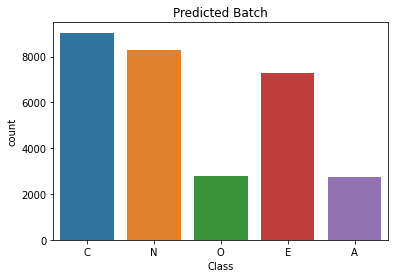

In [66]:
sns.countplot(results['Class'],order=target_classes)
plt.title('Test Data')
plt.show()

# Conclusion
- ds
- sd

# References
    [1]	M. F. Hornick, E. Marcadé, and S. Venkayala, “Chapter 3 - Data Mining Process,” in The Morgan Kaufmann Series in Data Management Systems, M. F. Hornick, E. Marcadé, and S. B. T.-J. D. M. Venkayala, Eds. Burlington: Morgan Kaufmann, 2007, pp. 51–83.
    [2]	“File:CRISP-DM Process Diagram.png - Wikimedia Commons.” .
    [3]	B. Tunguz, L. Petar, and M. Akdag, “Big Five Personality Test | 1M Answers to 50 personality items, and technical information.” [Online]. Available: https://www.kaggle.com/tunguz/big-five-personality-test. [Accessed: 20-Jun-2020].